# Machine Learning: the Gathering

In Magic: the Gathering, a collectable card game competitive players tend to gravitate towards a few dozen of the best decks made up out of a subset of all available cards. For instance in the Legacy format nearly all 18000 cards can be played, yet you'll only see about 500 show up in tournaments with some (e.g. Brainstorm and Force of Will) showing up in > 50% of all high-ranking decks.

When playing in such an event it is key to quickly identify your opponent's deck and adapt your own game plan accordingly. Top players are able to very quickly do this, bad ones like myself need a few more turns. Here we'll see if we can train a model that takes in a few known cards and outputs a prediction which deck is being played.

This notebook consists of a few sections:

  * Downloading the data (requests and Beautiful Soup)
  * Checking the data (pandas, seaborn)
  * Building a classifier (sklearn)
  * Balancing the dataset (imbalanced-learn, sklearn) and retraining a classifier
  * Running the model


## Step 01: getting some decklists

We'll get decklists from MTG Top 8 a website that collects decklists from the best 8 players in different tournaments. We'll focus on the Legacy format, using only decks from the last two weeks ( https://www.mtgtop8.com/format?f=LE&meta=34 ). Using Beautiful Soup we'll get all decks lists from the different archetypes.

This process is rather straightforward, we get the website using requests, pick up the links we want using Beautiful Soup, follow that links using requests, pick up the correct link again using Beautiful Soup and finally get the decklis using requests again. Parsing HTML tends to be tedious and if the website updates this will likely break.

You can pick up at Step 02 if you don't want to download these files. The results (from 29/12/2019) are included in this repository.

In [1]:
# Load all libraries

from bs4 import BeautifulSoup
import requests
import re
from tqdm import tqdm
import pandas as pd
from collections import Counter

from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
base_url = "https://www.mtgtop8.com/"
initial_url = base_url + "format?f=LE&meta=34"
deck_url = 'https://www.mtgtop8.com/mtgo?d=%s'

resp = requests.get(initial_url)
soup = BeautifulSoup(resp.text, 'html.parser')

In [ ]:
archetypes = {}
decks = {}

# First find all archetypes and the link to their details
for a in soup.find_all('a'):
    if "archetype" in a['href']:
        archetypes[a.string] = a['href']

pattern = re.compile("d=(\d+)")  # Regex to extract deck ID from url

# For each archetype get the deck IDs
for archetype, url in tqdm(archetypes.items()):
    current_url = base_url + url
    resp = requests.get(current_url)
    current_soup = BeautifulSoup(resp.text, 'html.parser')
    
    deck_urls = [a['href'] for a in current_soup.find_all('a') if 'event' in a['href'] and 'd=' in a['href']] 
    decks[archetype] =  [pattern.search(d).group(1) for d in deck_urls]
        

In [ ]:
# Fetch decklist
data = []

for archetype, deck_ids in tqdm(decks.items()):
    for i, deck_id in enumerate(deck_ids, start=1):
        current_url = deck_url % (deck_id)
        resp = requests.get(current_url)

        for line in resp.text.split("\r\n"):
            # We don't need the sideboard, break once this line is found
            if line.startswith("Sideboard"):
                break
            card_count, card_name = line.split(" ", 1)
            data.append({
                "archetype": archetype,
                "deck": archetype + ' ' + str(i),
                "card": card_name,
                "count": int(card_count)
            })


## Step 02: Data Science !

Now we got for each archetype all decks and all the main deck cards for that deck in a list of dictionaries, this can be directly converted into a pandas dataframe. Using the .pivot function we'll be able to convert that table into a count matrix.

We'll first prepare the dataframes and store them as csv files (comma separated values) so we can pick up from this point without downloading all decklists again.

In [ ]:
df = pd.DataFrame(data)
card_table = df.pivot(index='deck', columns='card', values='count').fillna(0)
archetype_df = df[["archetype", "deck"]].drop_duplicates().set_index("deck").reindex(card_table.index)

df.to_csv('decks_table.csv')
card_table.to_csv('card_table.csv')
archetype_df.to_csv('archetypes.csv')

In [3]:
# If you don't want to download the decklists yourself, start from this point 

df = pd.read_csv('decks_table.csv', index_col=0)
card_table = pd.read_csv('card_table.csv', index_col=0)
archetype_df = pd.read_csv('archetypes.csv', index_col=0)

In [4]:
# Let's do some sanity checks first

arch_counter = Counter(archetype_df['archetype'])
most_common = [a + '(' + str(c) + ')' for a,c in arch_counter.most_common(5)]
print("There are %d archetypes, the most popular ones are: %s" % (len(arch_counter), ', '.join(most_common)))

print("The 10 most popular cards:")
print(card_table.sum().sort_values(ascending=False).head(10))

There are 28 archetypes, the most popular ones are: UR Delver(6), Bant Control(5), Death & Taxes(4), UWx Control(4), Dark Depths(3)
The 10 most popular cards:
Brainstorm              112.0
Force of Will           108.0
Ponder                  103.0
Wasteland                88.0
Polluted Delta           71.0
Misty Rainforest         68.0
Swords to Plowshares     62.0
Flooded Strand           60.0
Thoughtseize             54.0
Verdant Catacombs        50.0
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


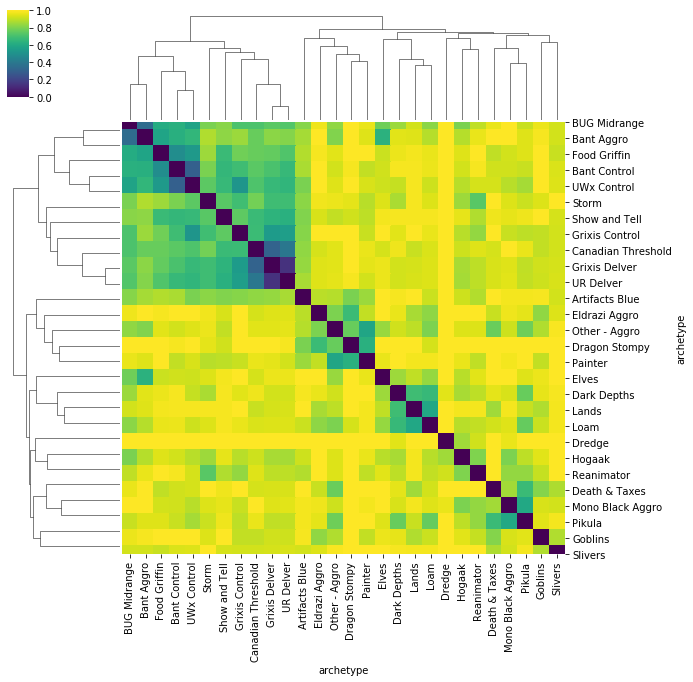

In [5]:
# Here we'll average all decks from the same archetype and create a family tree of decks

df_mean = df.groupby(['archetype', 'card'], as_index=False).mean()
df_mean = df_mean.pivot(index='archetype', columns='card', values='count').fillna(0)
df_mean.reset_index()

distances = pdist(df_mean.values, metric='braycurtis')
DistDf = pd.DataFrame(squareform(distances), columns=df_mean.index, index=df_mean.index)

g = sns.clustermap(DistDf, cmap='viridis')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()

## Step 03: Building a classifier

We'll first convert our card table into a present-absense matrix, where a one indicates a card is present in a deck (any number of copies) and a zero the card isn't present in a deck.


In [6]:
card_table_present_absent = card_table.applymap(lambda x: 1 if x > 0 else 0)
all_cards = list(card_table_present_absent.columns)
card_table_present_absent = pd.merge(archetype_df.reset_index(), card_table_present_absent, left_on='deck', right_on='deck')
card_table_present_absent.head()

,deck,archetype,Abrupt Decay,Ad Nauseam,Aether Vial,Altar of Dementia,Ancient Tomb,Ancient Ziggurat,Angrath's Rampage,Animate Dead,...,Watcher for Tomorrow,Waterlogged Grove,Wayward Servant,Whirlpool Rider,Wildborn Preserver,Windswept Heath,Wirewood Symbiote,Wishclaw Talisman,Wooded Foothills,Young Pyromancer
0,Artifacts Blue 1,Artifacts Blue,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BUG Midrange 1,BUG Midrange,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bant Aggro 1,Bant Aggro,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,Bant Control 1,Bant Control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bant Control 2,Bant Control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we need random subsets of cards from each deck in this format. To do this we will sample a number of random cards from each deck a number of times. This will become our final dataset to train the model on.

In [7]:
# Build training data

deck_data = []

for index, row in card_table_present_absent.iterrows():
    cards = [k for k,v in row.items() if v == 1]
    deck_data.append({
        'archetype' : row['archetype'],
        'cards': cards
    })
    


from random import shuffle

iterations = 1500
training_data = []

sizes = [4,5,6,7,10,20] # Samples to pick, for small sets of known cards we'll do a few more

for card_number in sizes:
    for deck in deck_data:
        cards = deck['cards']
        for i in range(iterations):
            shuffle(cards)
            selected_cards = cards[:card_number]

            training_data.append((deck['archetype'], [1 if c in selected_cards else 0 for c in all_cards]))
        
shuffle(training_data)

print("Prepared %d sets for training/testing" % len(training_data))

Prepared 522000 sets for training/testing


Now that we have data suited to train a model for our purpose we'll split the dataset in training and testing data. Next, we'll fit a Random Forest Classifier (RFC) on our training data and check it's performance on the test data.

In [8]:
# build X,y for training, the first n elements, defined by testsize, will be used for testing

testsize = 50000

X_train = [d[1] for d in training_data[testsize:]]
y_train = [d[0] for d in training_data[testsize:]]

X_test = [d[1] for d in training_data[:testsize]]
y_test = [d[0] for d in training_data[:testsize]]

training_data = []


from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=None, 
                             criterion= 'gini', 
                             max_features= 5, 
                             n_estimators= 50,
                             n_jobs=3)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=3,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
rfc.score(X_test, y_test)

0.96308

In [10]:
def predict_deck(cards_known):
    cards_array = [[1 if c in cards_known else 0 for c in all_cards]]

    decks_proba = rfc.predict_proba(cards_array)[0]

    decks = pd.DataFrame(list(zip(rfc.classes_, decks_proba)), columns=["Deck", "Score"])\
              .sort_values("Score", axis=0, ascending=False)

    return decks

Let's test our classifier on a few samples.

In [11]:
predict_deck(["Polluted Delta", "Underground Sea", "Brainstorm", "Force of Will"]).head(10)

,Deck,Score
27,UWx Control,0.265976
1,BUG Midrange,0.241381
14,Grixis Delver,0.230190
13,Grixis Control,0.202452
26,UR Delver,0.060000
3,Bant Control,0.000000
16,Lands,0.000000
25,Storm,0.000000
24,Slivers,0.000000
23,Show and Tell,0.000000


In [12]:
predict_deck(["Arcum's Astrolabe", "Snow-Covered Forest", "Brainstorm", "Noble Hierarch"]).head(5)

,Deck,Score
2,Bant Aggro,0.528
1,BUG Midrange,0.452
3,Bant Control,0.020
0,Artifacts Blue,0.000
16,Lands,0.000


To avoid retraining the data, the classifier is written to disk jusing the gzip and pickle library.

In [ ]:
import gzip, pickle

with gzip.open('all_samples.rfc.pickle.gz','wb') as fp:
    pickle.dump((all_cards, rfc), fp)

## Step 04: Dealing with imbalanced data

Some decks only appear once or twice in our dataset, while others are included up to 10 times. This creates an imbalance in our dataset with common decks being overrepresented. This type of imbalance thends to negatively affect a classifiers performance (as it can achieve good classifications always predicting the most common classes). 

This issue is easily addressed with a packaged **imbalanced learning**. Unfortunately, this isn't part of anaconda and can be installed using

```bash
conda install -c conda-forge imbalanced-learn
```
I hope this functionality will be included in sklearn itself as it is an essential component of many machine learning projects.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

By undersampling the abundant classes we do lose a lot of data, this was to be expected. In this case it isn't a big deal as we generated more than enough training data. We'll check if this worked as expected and train a new classifier on the undersampled dataset.

In [14]:
c = Counter(y_rus)
c.most_common()

[('Artifacts Blue', 8108),
 ('BUG Midrange', 8108),
 ('Bant Aggro', 8108),
 ('Bant Control', 8108),
 ('Canadian Threshold', 8108),
 ('Dark Depths', 8108),
 ('Death & Taxes', 8108),
 ('Dragon Stompy', 8108),
 ('Dredge', 8108),
 ('Eldrazi Aggro', 8108),
 ('Elves', 8108),
 ('Food Griffin', 8108),
 ('Goblins', 8108),
 ('Grixis Control', 8108),
 ('Grixis Delver', 8108),
 ('Hogaak', 8108),
 ('Lands', 8108),
 ('Loam', 8108),
 ('Mono Black Aggro', 8108),
 ('Other - Aggro', 8108),
 ('Painter', 8108),
 ('Pikula', 8108),
 ('Reanimator', 8108),
 ('Show and Tell', 8108),
 ('Slivers', 8108),
 ('Storm', 8108),
 ('UR Delver', 8108),
 ('UWx Control', 8108)]

In [15]:
rfc = RandomForestClassifier(max_depth=None, 
                             criterion= 'gini', 
                             max_features= 5, 
                             n_estimators= 50,
                             n_jobs=3)
rfc.fit(X_rus, y_rus)
rfc.score(X_test, y_test)

0.95394

In [16]:
predict_deck(["Arcum's Astrolabe", "Snow-Covered Forest", "Brainstorm", "Noble Hierarch"]).head(5)

,Deck,Score
2,Bant Aggro,0.516333
1,BUG Midrange,0.443667
27,UWx Control,0.020000
3,Bant Control,0.020000
16,Lands,0.000000


In [17]:
predict_deck(["Polluted Delta", "Underground Sea", "Brainstorm", "Force of Will"]).head(10)

,Deck,Score
13,Grixis Control,0.566333
1,BUG Midrange,0.373667
0,Artifacts Blue,0.020000
14,Grixis Delver,0.020000
27,UWx Control,0.020000
5,Dark Depths,0.000000
26,UR Delver,0.000000
25,Storm,0.000000
24,Slivers,0.000000
23,Show and Tell,0.000000


In [ ]:
import gzip, pickle

with gzip.open('balanced_samples.rfc.pickle.gz','wb') as fp:
    pickle.dump((all_cards, rfc), fp)

## Step 05: Load classifier and play with predictions


In this final part the classifier will be loaded from a pickle and you can play with predictions.



In [ ]:
import gzip, pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


with gzip.open('balanced_samples.rfc.pickle.gz','rb') as fp:
    (all_cards, rfc) = pickle.load(fp)

In [18]:
def predict_deck(cards_known):
    """
    This will take a list of known cards and convert it in a matrix compatible with the classifier.
    Next, this classifier will be used to predict which deck the known cards are coming from and 
    return the results as a sorted pandas dataframe.
    """
    cards_array = [[1 if c in cards_known else 0 for c in all_cards]]

    cards_not_in_model = [c for c in cards_known if c not in all_cards]
    
    if len(cards_not_in_model) > 0:
        print("Some cards were not included when trainig the model, these will be ignored: %s" % ','.join(cards_not_in_model))
    
    decks_proba = rfc.predict_proba(cards_array)[0]

    decks = pd.DataFrame(list(zip(rfc.classes_, decks_proba)), columns=["Deck", "Score"])\
              .sort_values("Score", axis=0, ascending=False)

    return decks

In [19]:
predict_deck(["Plains", "Mother of Runes", "Wasteland"]).head(5)

,Deck,Score
6,Death & Taxes,0.54
21,Pikula,0.40
19,Other - Aggro,0.04
17,Loam,0.02
0,Artifacts Blue,0.00


In [20]:
predict_deck(["Dark Confidant", "Forest", "Mox Diamond", "Swamp"]).head(5)

,Deck,Score
17,Loam,0.54
5,Dark Depths,0.44
16,Lands,0.02
0,Artifacts Blue,0.00
15,Hogaak,0.00


In [21]:
predict_deck(["Arcum's Astrolabe", "Snow-Covered Forest", "Brainstorm", "Noble Hierarch"]).head(5)

,Deck,Score
2,Bant Aggro,0.516333
1,BUG Midrange,0.443667
27,UWx Control,0.020000
3,Bant Control,0.020000
16,Lands,0.000000


In [22]:
predict_deck(["Polluted Delta", "Volcanic Island", "Underground Sea", "Brainstorm"]).head(5)

,Deck,Score
26,UR Delver,0.425
25,Storm,0.315
14,Grixis Delver,0.140
13,Grixis Control,0.060
1,BUG Midrange,0.040


In [23]:
predict_deck(['Birds of Paradise', "Snow-Covered Forest", "Windswept Heath", "Misthollow Griffin", "Force of Will"]).head(5)

,Deck,Score
11,Food Griffin,0.56
2,Bant Aggro,0.14
19,Other - Aggro,0.14
27,UWx Control,0.08
3,Bant Control,0.04


In [24]:
predict_deck(["Arcum's Astrolabe", "Snow-Covered Swamp", "Brainstorm", "Polluted Delta", "Snow-Covered Island", "Ponder"]).head(5)

,Deck,Score
27,UWx Control,0.621667
13,Grixis Control,0.140000
3,Bant Control,0.118333
1,BUG Midrange,0.100000
23,Show and Tell,0.020000


In [25]:
predict_deck(["Arcum's Astrolabe", "Snow-Covered Swamp", "Polluted Delta",  "Snow-Covered Forest", "Brainstorm", "Ponder"]).head(5)

,Deck,Score
27,UWx Control,0.32
3,Bant Control,0.26
1,BUG Midrange,0.26
13,Grixis Control,0.14
2,Bant Aggro,0.02


## Conclusion

This seems to work very well and can easily be adapted for other formats as well. Do note that manual curation could improve these prediction. For instance the UWx Control decks are very diverse and the classifier would likely perform better if this class was removed.

Overall a cool application of machine learning I haven't seen before ! 
